NESTML spike frequency adaptation tutorial
==========================================

Welcome to the NESTML spike frequency adaptation (SFA) tutorial. Here, we will go step by step through adding two different types of SFA mechanism to a neuron model, threshold adaptation and an adaptation current [1], and then evaluate how the new models behave in simulation.

#### Table of contents

- [Introduction](#introduction)
- [Threshold-based SFA](#threshold-based-adaptation)
- [Current-based SFA](#current-based-adaptation)

<a name="introduction"></a>

Introduction
------------

A neuron that is stimulated by rectangular current injections initially responds with a high firing rate, followed by a decrease in the firing rate. This phenomenon is called *spike-frequency adaptation* and is usually mediated by slow K<sup>+</sup> currents, such as a Ca<sup>2+</sup>-activated K<sup>+</sup> current [3]. This behaviour is typically modelled in one of two ways:

*Threshold adaptation:* The threshold for generating an action potential is increased every time an action potential occurs. The threshold slowly decays back to its original value.

*Potassium membrane current:* An extra transmembrane current is added to the neuron, that is increased step-wise every time an action potential occurs, and slowly decays back to its original value.

**Quiz:** If a typical point neuron model has a characteristic timescale (in its membrane potential dynamics) of 20&nbsp;ms, what would be good order-of-magnitude estimate to give to the adaptation characteristic timescale? How does refractoriness figure into this?

**Solution:** Considerably longer than the neuron timescale, e.g. 200 ms; refractoriness defines a maximum neuron firing rate; consider maximum and minimum obtained firing rates in the presence of the SFA mechanism.

In [1]:
%matplotlib inline

from typing import List, Optional

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import random
import re
import uuid

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Generating code with NESTML

We will take a simple current-based integrate-and-fire model with alpha-shaped postsynaptic response kernels (``iaf_psc_alpha``) as the basis for our modifications. First, let's take a look at this base neuron without any modifications.

We will use a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "iaf_psc_alpha_3cc945f". The resulting neuron model name is returned by the function, so we do not have to think about these internals.

### Base model: no adaptation

Let's first make sure that we have all the necessary files.

If you are running this notebook locally or cloned the repository, the NESTML model ``iaf_psc_alpha_neuron.nestml`` is contained in the subdirectory ``models``. You can open NESTML model files in your favourite code editor (check https://github.com/nest/nestml/ for syntax highlighting support). In case you are running this notebook in JupyerLab, you can edit the model files directly in your browser via the "File browser" panel on the left.

In [2]:
# generate and build code
module_name, neuron_model_name_no_sfa = \
    NESTCodeGeneratorUtils.generate_code_for("models/iaf_psc_alpha.nestml")

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



CMake Warning:
  Ignoring empty string ("") provided on the command line.


CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_7eebc3c02a3040df86acdab2a99d6e38_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -std=c++11 -Wall -fopenmp -O2 -fdiagnostics-color=auto
NEST include dirs    :

Now, the NESTML model is ready to be used in a simulation.

In [3]:
def evaluate_neuron(neuron_name, neuron_parms=None, stimulus_type="constant",
                    mu=500., sigma=0., t_sim=300., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    dt = .1   # [ms]

    nest.ResetKernel()
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    
    if stimulus_type == "constant":
        nest.SetStatus(neuron, "I_e", mu)
        assert sigma == 0.
    elif stimulus_type == "Ornstein-Uhlenbeck":
        nest.SetStatus(neuron, "I_noise0", mu)
        nest.SetStatus(neuron, "sigma_noise", sigma)
    else:
        raise Exception("Unknown stimulus type: " + str(stimulus_type))
    
    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    spike_recorder = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    
    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
    dSD = nest.GetStatus(spike_recorder, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()

    return ts


Oct 19 03:51:59 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:51:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:51:59 SimulationManager::run [Info]: 
    Simulation finished.


array([ 13.9,  29.8,  45.7,  61.6,  77.5,  93.4, 109.3, 125.2, 141.1,
       157. , 172.9, 188.8, 204.7, 220.6, 236.5, 252.4, 268.3, 284.2])

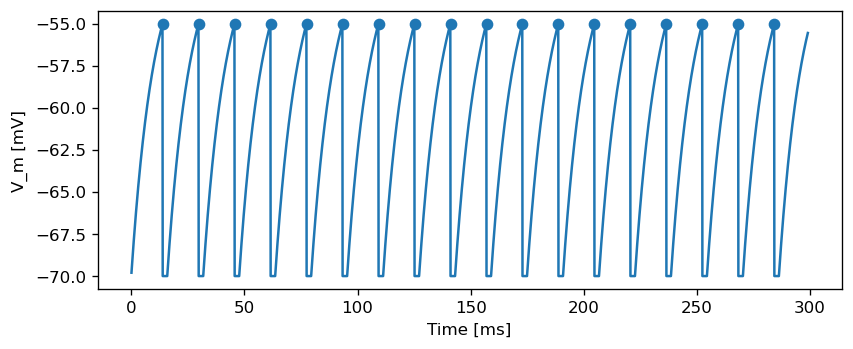

In [4]:
evaluate_neuron(neuron_model_name_no_sfa)

<a name="current-based-adaptation"></a>

Current-based adaptation
------------------------

Specifically incorporate an adaptation current $I_{sfa}(t)$ while keeping the firing threshold constant. The current will always be non-negative, and is set up so that the current will hyperpolarise the neuron. The dynamical system model is adjusted in this case to

\begin{align}
\frac{dV_m}{dt} &= (I_{syn} + I_{ext} - I_{sfa}) / \tau_m\\
\frac{dI_{sfa}}{dt} &= -I_{sfa} / \tau_{sfa}
\end{align}

where $I_{sfa}$ is instantaneously increased by $\Delta{}I_{sfa}$ at each the neuron fires and $\tau_{sfa}$ controls the decay rate for the adaptation current.

### Adjusting the NESTML model

**Task:** Create a new file and name it, for example, ``iaf_psc_alpha_adapt_curr.nestml``. Copy the contents of ``iaf_psc_alpha_neuron.nestml`` and make the following changes.

First, define the parameters:  

```
parameters:
    [...]
    tau_sfa ms = 100 ms
    Delta_I_sfa pA = 100 pA
```

Add the new state variables and initial values:
```
state:
    [...]
    I_sfa pA = 0 pA
```

```
equations:
    [...]
    I_sfa' = -I_sfa / tau_sra
```

and add the new term to the dynamical equation for `V_m`:
```
equations:
    [...]
    function I pA = convolve(I_shape_in, in_spikes) + convolve(I_shape_ex, ex_spikes) - I_sfa + I_e + I_stim
    V_m' = -(V_m - E_L) / Tau + I / C_m
```

Increment the adaptation current whenever the neuron fires:

```
onCondition(V_m >= Theta):
    [...]
    I_sfa += Delta_I_sfa
    emit_spike()
```

In [5]:
# generate and build code
module_name, neuron_model_name_adapt_curr = \
    NESTCodeGeneratorUtils.generate_code_for("models/iaf_psc_alpha_adapt_curr.nestml")

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



CMake Warning:
  Ignoring empty string ("") provided on the command line.


CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_cf4b4fa998ce469bb5922408c671e12d_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -std=c++11 -Wall -fopenmp -O2 -fdiagnostics-color=auto
NEST include dirs    :


Oct 19 03:52:28 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:28 SimulationManager::run [Info]: 
    Simulation finished.


array([ 13.9,  39.4,  89.8, 154.8, 220.6, 286.4])

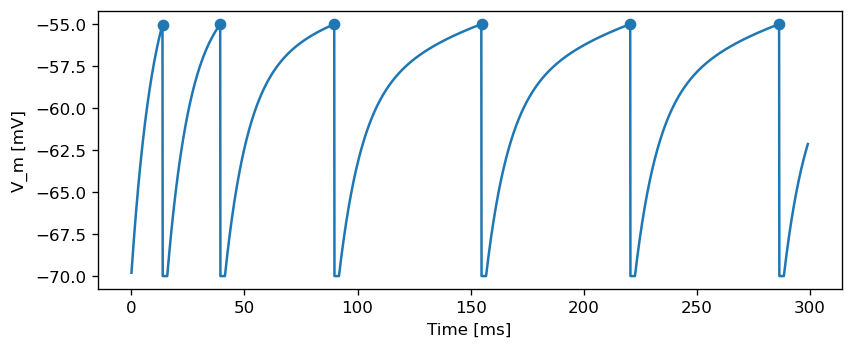

In [6]:
evaluate_neuron(neuron_model_name_adapt_curr)

**Task:** Record and plot the adaptation current $I_{sfa}$.

<a name="threshold-based-adaptation"></a>

Threshold-based adaptation
--------------------------

We reflect spike-frequency adaptation by increasing the firing threshold $\Theta$ by $\Delta\Theta$ the moment the neuron fires. Between firing events, $\Theta$ evolves according to

\begin{align}
\frac{d\Theta}{dt} &= -(\Theta - \Theta_{init}) / \tau_\Theta
\end{align}

such that the firing threshold decays to the constant non-adapted firing threshold, in the absence of firing events, and $\tau_\Theta$ determines the decay rate.

**Task:** As for the threshold adaptation case, create a new model file and make the necessary adjustments.

In [7]:
# generate and build code
module_name, neuron_model_name_adapt_thresh = \
    NESTCodeGeneratorUtils.generate_code_for("models/iaf_psc_alpha_adapt_thresh.nestml")

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



CMake Warning:
  Ignoring empty string ("") provided on the command line.


CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_3d5d4b21a5314a528dd55b99ac51154e_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -std=c++11 -Wall -fopenmp -O2 -fdiagnostics-color=auto
NEST include dirs    :


Oct 19 03:52:48 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:48 SimulationManager::run [Info]: 
    Simulation finished.


array([ 13.9,  33.9,  58.6,  88.3, 122.2, 158.8, 196.7, 235.2, 273.9])

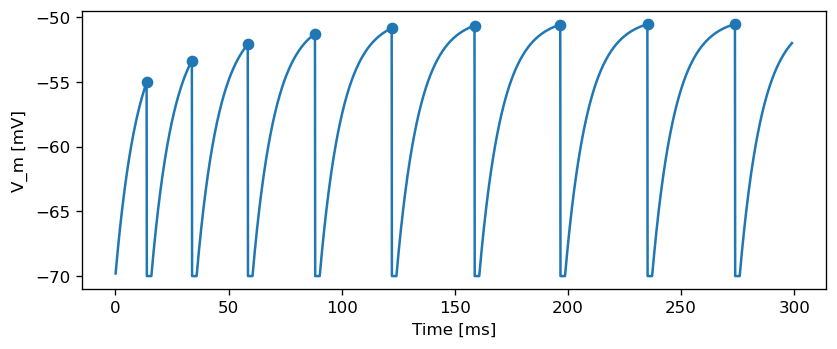

In [8]:
evaluate_neuron(neuron_model_name_adapt_thresh)

### Slope-dependent threshold

As an extra challenge: implement the slope-dependent threshold from https://www.pnas.org/content/97/14/8110

Characterisation
----------------

We now use various metrics to quantify and compare the behavior of the different neuron model variants.

### f-I curve




In [9]:
def measure_fI_curve(I_stim_vec, neuron_model_name):
    r"""For a range of stimulation currents ``I_stim_vec``, measure the steady
    state firing rate of the neuron ``neuron_model_name`` and return them as a
    vector ``rate_testant`` of the same size as ``I_stim_vec``."""
    t_stop = 10000.   # simulate for a long time to make any startup transients insignificant [ms]

    rate_testant = float("nan") * np.ones_like(I_stim_vec)
    for i, I_stim in enumerate(I_stim_vec):
        nest.ResetKernel()
        neuron = nest.Create(neuron_model_name)

        dc = nest.Create("dc_generator", params={"amplitude": I_stim * 1E12}) # 1E12: convert A to pA
        nest.Connect(dc, neuron)

        sr_testant = nest.Create('spike_recorder')
        nest.Connect(neuron, sr_testant)

        nest.Simulate(t_stop)

        rate_testant[i] = sr_testant.n_events / t_stop * 1000

    return rate_testant

In [10]:
def plot_fI_curve(I_stim_vec, label_to_rate_vec):
    if len(I_stim_vec) < 40:
        marker = "o"
    else:
        marker = None
    fig, ax = plt.subplots()
    ax = [ax]
    for label, rate_vec in label_to_rate_vec.items():
        ax[0].plot(I_stim_vec * 1E12, rate_vec, marker=marker, label=label)
    for _ax in ax:
        _ax.legend(loc='upper right')
        _ax.grid()
        _ax.set_ylabel("Firing rate [Hz]")
    ax[0].set_xlabel("$I_{inj}$ [pA]")
    plt.tight_layout()



Oct 19 03:52:48 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:48 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:52:48 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:48 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:52:48 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:48 SimulationManager::run [Info]: 
    Simulation


Oct 19 03:52:49 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:49 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:52:49 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:49 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:52:49 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:52:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:52:49 SimulationManager::run [Info]: 
    Simulation

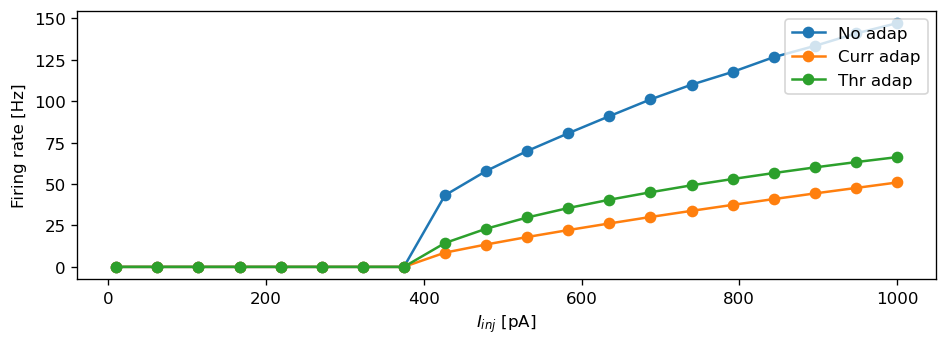

In [11]:
I_stim_vec = np.linspace(10E-12, 1E-9, 20)     # [A]
rate_vec = measure_fI_curve(I_stim_vec, neuron_model_name_no_sfa)
rate_vec_adapt = measure_fI_curve(I_stim_vec, neuron_model_name_adapt_curr)
rate_vec_thresh_adapt = measure_fI_curve(I_stim_vec, neuron_model_name_adapt_thresh)
plot_fI_curve(I_stim_vec, {"No adap": rate_vec,
                           "Curr adap" : rate_vec_adapt,
                           "Thr adap" : rate_vec_thresh_adapt})

**Task:** Can you make the current adaptation model curve and threshold adaptation curve overlap? Can you do this without re-generating the NESTML models?

### CV vs. firing rate

The Ornstein-Uhlenbeck process is often used as a source of noise because it is well understood and has convenient properties (it is a Gaussian process, has the Markov property, and is stationary). Let the O-U process, denoted $U(t)$ (with $t\geq 0$) , be defined as the solution of the following stochastic differential equation:

\begin{align}
\frac{dU}{dt} = \frac{\mu - U}{\tau} + \sigma\sqrt{\frac 2 \tau} \frac{dB(t)}{dt}
\end{align}

The first right-hand side term is a "drift" term which is deterministic and slowly reverts $U_t$ to the mean $\mu$, with time constant $\tau$. The second term is stochastic as $B(t)$ is the Brownian motion (also "Wiener") process, and $\sigma>0$ is the standard deviation of the noise.

It turns out that the infinitesimal step in Brownian motion is white noise, that is, an independent and identically distributed sequence of Gaussian $\mathcal{N}(0, 1)$ random variables. The noise $dB(t)/dt$ can be sampled at time $t$ by drawing a sample from that Gaussian distribution, so if the process is sampled at discrete intervals of length $h$, we can write (equation 2.47 from [[1]](#References)):

\begin{align}
U(t + h) = (U(t) - \mu)\exp(-h/\tau) + \sigma\sqrt{(1 - \exp(-2h / \tau ))} \cdot\mathcal{N}(0, 1)
\end{align}

We can write this in NESTML as:

```
parameters:
    I_noise0 pA = 500 pA      # mean of the noise current
    sigma_noise pA = 50 pA    # std. dev. of the noise current

internals:
    [...]
    D_noise pA**2/ms = 2 * sigma_noise**2 / tau_syn
    A_noise pA = ((D_noise * tau_syn / 2) * (1 - exp(-2 * resolution() / tau_syn )))**.5
```

```
state:
    I_noise pA = I_noise0
```

```
update:
    [...]
    I_noise = I_noise0
            + (I_noise - I_noise0) * exp(-resolution() / tau_syn)
            + A_noise * random_normal(0, 1)
```


In [12]:
# generate and build code
module_name, neuron_model_name_adapt_thresh_ou = \
    NESTCodeGeneratorUtils.generate_code_for("models/iaf_psc_alpha_adapt_thresh_OU.nestml")

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



CMake Warning:
  Ignoring empty string ("") provided on the command line.


CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_7f7508b0764a4864aedebc17252a1670_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -std=c++11 -Wall -fopenmp -O2 -fdiagnostics-color=auto
NEST include dirs    :

Let's first do some sanity check that our model is behaving as expected. If we set $\sigma$ to zero, the response should match the one for the constant current input, so the following two plots should look exactly the same:


Oct 19 03:53:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:10 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:10 SimulationManager::run [Info]: 
    Simulation finished.


array([ 16.1,  36.1,  60.8,  90.5, 124.4, 161. , 198.9, 237.4, 276.1])

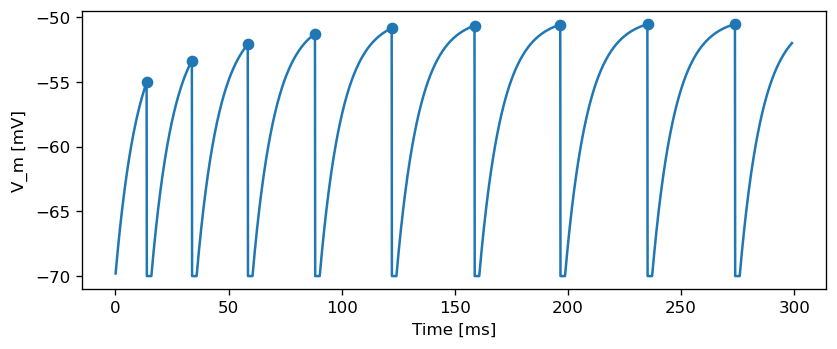

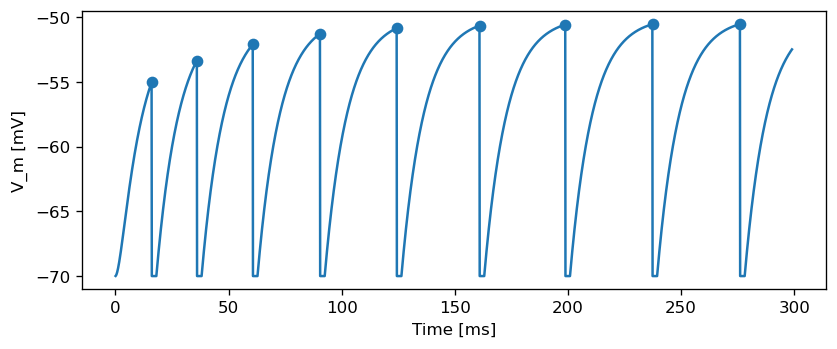

In [13]:
evaluate_neuron(neuron_model_name_adapt_thresh_ou, stimulus_type="constant", mu=500.)
evaluate_neuron(neuron_model_name_adapt_thresh_ou, stimulus_type="Ornstein-Uhlenbeck", mu=500., sigma=0.)

Now, for the same $\mu$=500 pA, but setting $\sigma$=200 pA/√ms, the effect of the noise can be clearly seen in the membrane potential trace and in the spiking irregularity: 


Oct 19 03:53:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:10 SimulationManager::run [Info]: 
    Simulation finished.


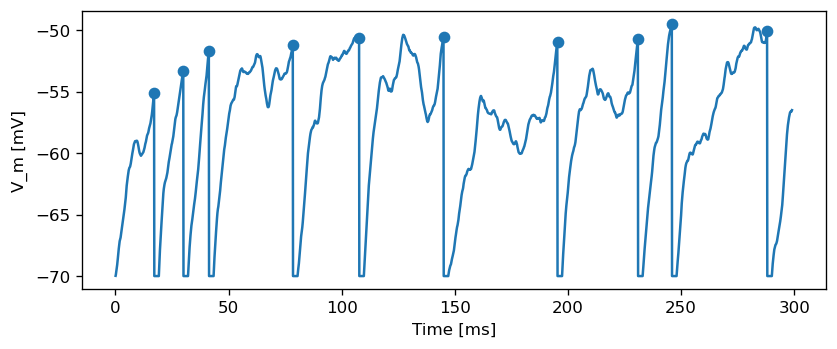

In [14]:
spike_times = evaluate_neuron(neuron_model_name_adapt_thresh_ou,
                              stimulus_type="Ornstein-Uhlenbeck",
                              mu=500.,
                              sigma=200.)

Let's first do a sanity check and plot a distribution of the interspike intervals, as well as their mean and standard deviation interval.


Oct 19 03:53:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:11 SimulationManager::run [Info]: 
    Simulation finished.
Mean: 35.57857142857143
Std. dev.: 15.445684953198752


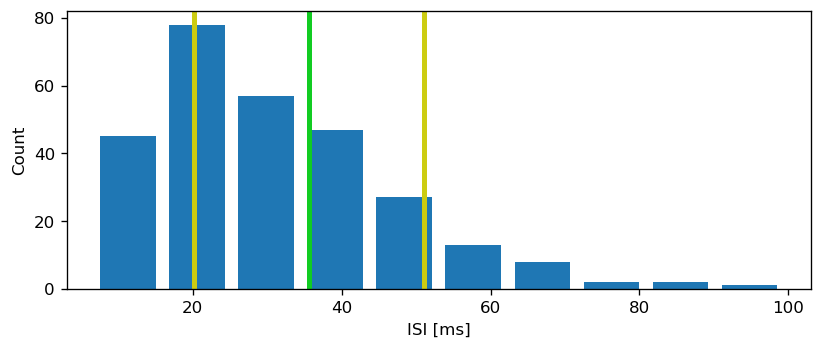

In [15]:
spike_times = evaluate_neuron(neuron_model_name_adapt_thresh_ou,
                              stimulus_type="Ornstein-Uhlenbeck",
                              mu=500.,
                              sigma=200.,
                              t_sim=10000.,
                              plot=False)

ISI = np.diff(spike_times)
ISI_mean = np.mean(ISI)
ISI_std = np.std(ISI)

print("Mean: " + str(ISI_mean))
print("Std. dev.: " + str(ISI_std))

count, bin_edges = np.histogram(ISI)

fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], count, width=.8 * (bin_edges[1] - bin_edges[0]))
ylim = ax.get_ylim()
ax.plot([ISI_mean, ISI_mean], ax.get_ylim(), c="#11CC22", linewidth=3)
ax.plot([ISI_mean - ISI_std, ISI_mean - ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.plot([ISI_mean + ISI_std, ISI_mean + ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.set_ylim(ylim)
ax.set_xlabel("ISI [ms]")
ax.set_ylabel("Count")
ax.grid()


**Task:** The CV is defined as the standard deviation of the ISIs divided by the mean:

\begin{align}
CV = \frac{\sigma}{\mu}
\end{align}

Comment on whether the coefficient of variation is an appropriate metric to use.

Now, we can use the ISIs to calculate the coefficient of variation. Sanity check: Poisson process should have CV = 1 irrespective of the rate.

In [16]:
mean_interval = 1.
isi = np.random.exponential(mean_interval, 1000)
print("For a Poisson process:")
print("CV = " + str(np.std(isi) / np.mean(isi)))

For a Poisson process:
CV = 0.9727915126649517


In [17]:
CV = np.std(ISI) / np.mean(ISI)
print("CV: " + str(np.std(ISI) / np.mean(ISI)))

CV: 0.4341288683894449


Let's compute the CV across a range of input currents and compare this to the non-adapting model:

In [18]:
def cv_across_curr(neuron_model_name, neuron_params, N=40):
    t_sim = 25E3  # [ms]
    CV = np.nan * np.ones(N)
    rate = np.nan * np.ones(N)
    for i, mu in enumerate(np.logspace(np.log10(150.), np.log10(700.), N)):
        spike_times = evaluate_neuron(neuron_model_name,
                                      stimulus_type="Ornstein-Uhlenbeck",
                                      mu=mu,
                                      sigma=100.,
                                      t_sim=t_sim,
                                      plot=False,
                                      neuron_parms=neuron_params)

        rate[i] = len(spike_times) / (t_sim / 1E3)

        ISI = np.diff(spike_times)
        if len(ISI) > 0:
            ISI_mean = np.mean(ISI)
            ISI_std = np.std(ISI)
            CV[i] = ISI_std / ISI_mean

    return CV, rate


Oct 19 03:53:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:11 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:11 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:11 SimulationManager::run [Info]: 
    Simulation


Oct 19 03:53:16 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:16 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:17 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:17 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:18 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:18 SimulationManager::run [Info]: 
    Simulation


Oct 19 03:53:33 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:33 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:33 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:33 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:33 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:33 SimulationManager::run [Info]: 
    Simulation


Oct 19 03:53:39 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:39 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:40 SimulationManager::run [Info]: 
    Simulation finished.


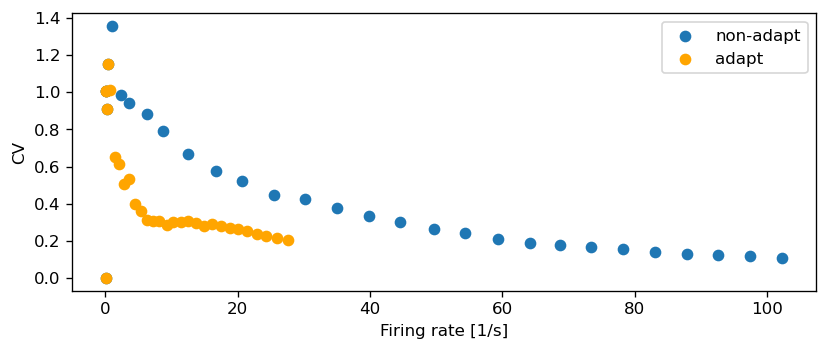

In [19]:
CV_reg, rate_reg = cv_across_curr(neuron_model_name_adapt_thresh_ou, {"Delta_Theta" : 0.})
CV_adapt, rate_adapt = cv_across_curr(neuron_model_name_adapt_thresh_ou, {"Delta_Theta" : 5.})

fig, ax = plt.subplots()
ax.scatter(rate_reg, CV_reg, label="non-adapt")
ax.scatter(rate_adapt, CV_adapt, color="orange", label="adapt")
ax.set_xlabel("Firing rate [1/s]")
ax.set_ylabel("CV")
ax.legend()
ax.grid()

**Task:** What can you conclude about the behaviour of the adaptive neuron model on the basis of this diagram? In what ways is it qualitatively different from the non-adapting model?


Spike train autocorrelation
---------------------------

Autocorrelogram: histogram of time differences between (not necessarily adjacent) spikes.


In [20]:
def spike_train_autocorrelation(spike_times, half_wind=50., plot=True):
    """
    Parameters
    ----------
    half_wind : float
        Half the window size in milliseconds.
    """

    times = []
    for t1 in spike_times:
        for t2 in spike_times:
            times.append(t2 - t1)

    count, bin_edges = np.histogram(times, bins=41, range=(-half_wind, half_wind))
    count = np.array(count) / len(times)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.

    if plot:
        fig, ax = plt.subplots()
        #ax.bar(bin_centers, count, width=.8 * (bin_edges[1] - bin_edges[0]))
        ax.plot(bin_centers, count, marker="o")
        ax.set_xlabel("$\\Delta$t [ms]")
        ax.grid()

    return bin_edges, count

The spike autocorrelogram for a regularly spiking neuron should show peaks at the firing period, and multiples thereof:

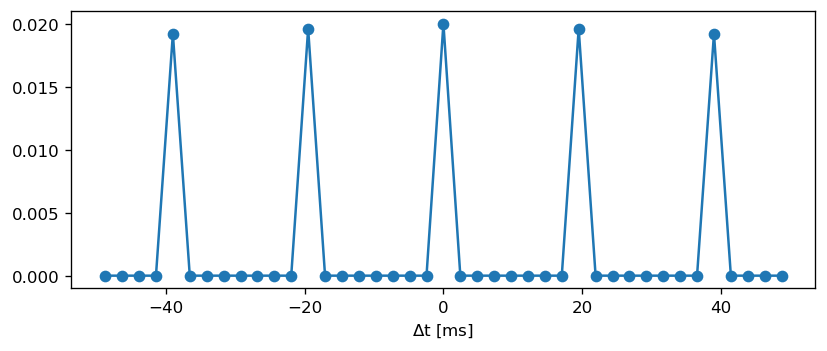

In [21]:
spike_times = np.arange(0., 1000., 20.) 
_ = spike_train_autocorrelation(spike_times)

The spike autocorrelogram for a Poisson process should only show a peak around $\Delta{}t$=0 for any rate:

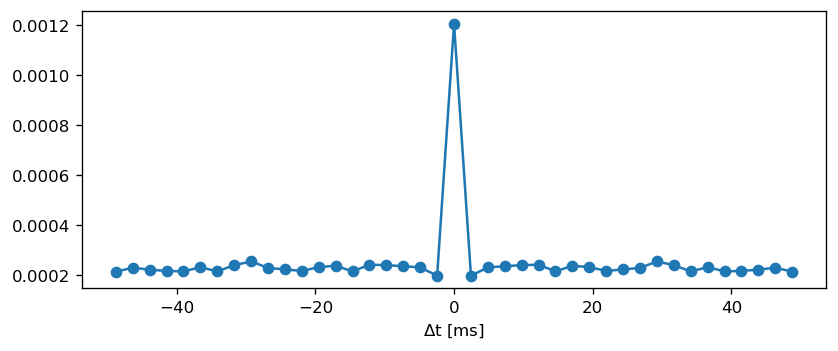

In [22]:
spike_times = np.cumsum(np.random.exponential(10., 1000))  # cumsum turns ISIs into sequential spike times
_ = spike_train_autocorrelation(spike_times)

**Task:** Use the ``spike_train_autocorrelation()`` function to determine if neurons with and without adaptation are Poissonian in their response, when driven with a noisy input.


Oct 19 03:53:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:41 SimulationManager::run [Info]: 
    Simulation finished.

Oct 19 03:53:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Oct 19 03:53:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:53:41 SimulationManager::run [Info]: 
    Simulation finished.


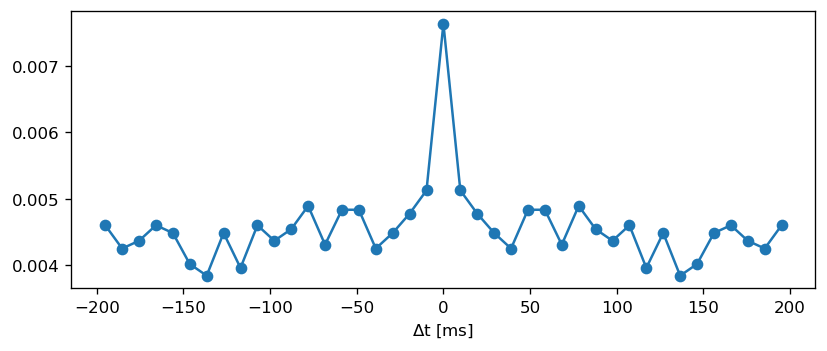

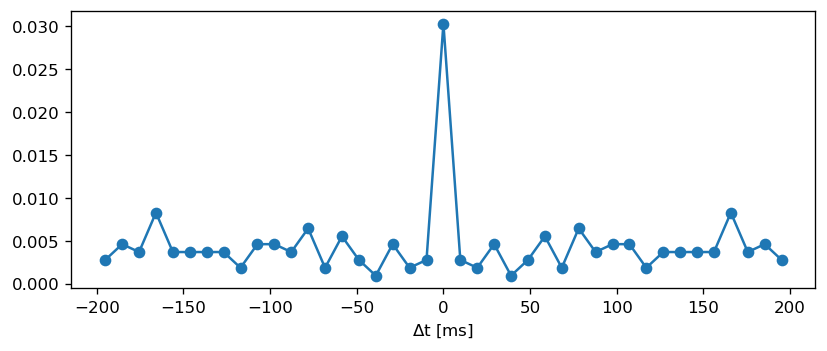

In [23]:
def autocorr(spike_times):
    ISI = np.diff(spike_times)
    num = 0.
    den = 0.
    for i in range(len(ISI) - 1):
        num += ISI[i] * ISI[i+1] - np.mean(ISI)**2
        den += ISI[i]**2 - np.mean(ISI)**2
        
    sum = num / den / (len(ISI) - 1)
    return sum

N = 2
c = np.nan * np.ones(N)
rate = np.nan * np.ones(N)
mu = 500.
for i, dth in enumerate(np.linspace(0., 10., N)):
    spike_times = evaluate_neuron(neuron_model_name_adapt_thresh_ou,
                                  stimulus_type="Ornstein-Uhlenbeck",
                                  mu=mu,
                                  sigma=500.,
                                  t_sim=2000.,
                                  plot=False,
                                  neuron_parms={"Delta_Theta" : dth,
                                                "tau_Theta" : 100.})
    _ = spike_train_autocorrelation(spike_times, half_wind=200.)
    isi = np.diff(spike_times)
    c[i] = np.std(isi) / np.mean(isi)#autocorr(spike_times)
    times = []
    for t1 in spike_times:
        for t2 in spike_times:
            times.append(t2 - t1)

    rate[i] = len(spike_times) / 10.

### More characterisation

**Meta task:** How would you improve this tutorial? Extend it and share by submitting a pull request on https://github.com/nest/nestml/!

For more inspiration, try to reproduce the following figures:

- Figure 5D from [2]
- Autocorrelation: figure 8D from [3]
- ISI correlation coefficient: figure 8B from [4]

Or try to see what the effect is of eliminating the membrane potential reset after spiking in the adaptive threshold model [2].

References
----------

[1] Victor J. Barranca, Han Huang, and Sida Li. The impact of spike-frequency adaptation on balanced network dynamics. Cogn Neurodyn. 2019 Feb; 13(1): 105–120. https://doi.org/10.1007/s11571-018-9504-2

[2] Rony Azouz and Charles M. Gray. Dynamic spike threshold reveals a mechanism for synaptic coincidence detection in cortical neurons in vivo. PNAS July 5, 2000 97 (14) 8110-8115; https://doi.org/10.1073/pnas.130200797

[3] Ryota Kobayashi & Katsunori Kitano. "Impact of slow K+ currents on spike generation can be described by an adaptive threshold model" Journal of Computational Neuroscience volume 40, pages 347–362 (2016) https://link.springer.com/article/10.1007/s10827-016-0601-0#Equ8

[4] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1995006/










